### Setup

In [5]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()


In [6]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

### Setup input pipeline

In [62]:
#with_info = True -> tfds.load가 dataset과 metadata를 반환
#as_supervised = False -> dataset을 dictionary로 반환
#as_supervised = True -> dataset을 tensor형태로 반환
dataset, info = tfds.load('imdb_reviews', with_info=True,
                        as_supervised = True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# train dataset의 유형 반환/ text와 label pairs로 반환하게 된다.
train_dataset.element_spec
#train_dataset.dtype

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [44]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='C:\\Users\\pgho8\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_s

In [53]:
#train_dataset[0]
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [61]:
for example in train_dataset.take(1):
    print(example)


{'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'text': <tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">}


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

'''
train_dataset -> label -> 앞에서 1만개 범위 안에서 데이터를 섞어줘라
train_dataset.shuffle(BUFFER_SIZE)

batch -> 섞은 데이터 안에서 64만큼 뽑아라!!
'''

In [10]:
#shuffle -> 범위 안(BUFFER_SIZE)에서 데이터를 섞어줌
#batch -> shuffle된 범위 안에서 데이터 선정
#prefectch(tf.data.AUTOTUNE) -> 훈련 최대 스텝시간과 데이터 추출하는데 걸리는 시간 단축
# 데이터를 불러오고 학습하는데 시간을 단축시키는 역할을 한다!
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
for example, label in train_dataset.take(1):
    print('texts:', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts: [b"It's this sort of movie that you try and imitate. By attempting to realise something... then flying through the air almost immediately. I'd like to do that and I know you would too!<br /><br />Great stuff!"
 b'Final Justice has the great Joe Don Baker running around Texas, shooting people who shoot people. Then he\'s off to Malta where he shoots more people. He gets locked up many times for shooting people. Then he gets into a gunfight with the bad guy, who is dressed like a monk. There is a boat chase, and Joe Don winds up in jail again. Finally Joe Don, with the help from Elaine from "Seinfeld" kill the bad guy, blow up a boat or two and someone gets shot with a flare. All this and a catchy theme song, just like Mitchell!'
 b'WHEN FRIENDSHIP KILLS, in my opinion, is a very touching and kind of heartbreaking drama about the consequences of being anorexic or bulimic. Anytime Lexi (Katie Wright) or Jennifer (Marley Shelton) threw up, I wanted to vomit myself. It\'s kind of har

### Create the text encoder

In [13]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens = VOCAB_SIZE
)
#sklearn에서 fit하는 과정
#map은 train_dataset에서 text와 label 중에서 text만 꺼내서 TextVectorization에 fit하는 과정
#encoder.fit(train_dataset.map(lambda text,label: text))
encoder.adapt(train_dataset.map(lambda text, label: text))


In [15]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [55]:
#encoder에서 vocab_size를 1000으로 지정했기 때문
len(vocab)
# vocab[464]

1000

In [70]:
vocab[425]

'sort'

In [18]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 30,  11, 425, ...,   0,   0,   0],
       [464,   1,  44, ...,   0,   0,   0],
       [ 51,   1,   1, ...,   0,   0,   0]], dtype=int64)

In [57]:
import pandas as pd

# vocab index로 문장을 구성하기!
pd.DataFrame(encoded_example)

,0,1,2,3,4,5,6,7,8,9,...,540,541,542,543,544,545,546,547,548,549
0,30,11,425,5,18,12,23,337,3,1,...,0,0,0,0,0,0,0,0,0,0
1,464,1,44,2,85,885,1,1,611,184,...,0,0,0,0,0,0,0,0,0,0
2,51,1,1,8,56,656,7,4,53,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b"It's this sort of movie that you try and imitate. By attempting to realise something... then flying through the air almost immediately. I'd like to do that and I know you would too!<br /><br />Great stuff!"
Round-trip:  its this sort of movie that you try and [UNK] by [UNK] to [UNK] something then [UNK] through the air almost [UNK] id like to do that and i know you would [UNK] br great stuff                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Original:  b'Final Justice has the great Joe Don Baker running around Texas, 

### Create the model

#### 단어의 분산표현!  
분포 가설(distribution hypothesis)? : 유사한 맥락에서 나타나는 단어는 그 의미도 비슷하다  

#### LSTM의 역할

유사한 맥락에 나타난 단어들끼리는 두 단어 벡터 사이의 거리를 가깝게 하고, 그렇지 않은 단어들끼리는 멀어지도록 조금씩 조정 [이렇게 얻어지는 단어 벡터 : 분산 표현(Distributed Representation)]  

분산 표현을 사용하면 희소 표현과는 다르게 단어 간의 유사도를 계산으로 구할 수 있음!

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbzkjtG%2FbtrsSvTlAX4%2FrRIusRNzOqocOd1ZwC7lck%2Fimg.png'>

In [58]:
model = tf.keras.Sequential([
    encoder,
    #Embedding 과정이 필요한 이유 -> 각 단어의 encoder를 지정된 차원으로 벡터화시켜주기 위함
    #분포 가설에 따라 모든 단어를 고정 차원 (예를 들어 64차원)의 벡터로 표현
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


### 양방향(Bidirectional) RNN

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbsV7Oo%2FbtrsSkqRALe%2FRi5aPH3yutWkySYkDWwyY1%2Fimg.jpg'></br>
해당 빈 칸 안에 알맞게 단어를 넣으려면, 앞 뒤를 다 봐야하는데, 순차 RNN으로는 문제가 있다.

In [29]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [30]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.00119075]


In [31]:
padding = 'the ' * 2000
predictions = model.predict(np.array([sample_text,padding]))
print(predictions[0])

1/1 [==============================] - 0s 220ms/step
[0.00119075]


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.Adam(1e-4),
            metrics = ['accuracy'])

### Train the model

In [35]:
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 881s 2s/step - loss: 0.4505 - accuracy: 0.7674 - val_loss: 0.3957 - val_accuracy: 0.7995
Epoch 2/5
391/391 [==============================] - 762s 2s/step - loss: 0.3514 - accuracy: 0.8427 - val_loss: 0.3505 - val_accuracy: 0.8344
Epoch 3/5
391/391 [==============================] - 756s 2s/step - loss: 0.3266 - accuracy: 0.8566 - val_loss: 0.3966 - val_accuracy: 0.7911
Epoch 4/5
391/391 [==============================] - 729s 2s/step - loss: 0.3158 - accuracy: 0.8630 - val_loss: 0.3479 - val_accuracy: 0.8589
Epoch 5/5
391/391 [==============================] - 779s 2s/step - loss: 0.3066 - accuracy: 0.8686 - val_loss: 0.3214 - val_accuracy: 0.8557


In [36]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 141s 362ms/step - loss: 0.3146 - accuracy: 0.8585
Test Loss: 0.31463128328323364
Test Accuracy: 0.858519971370697


(0.0, 0.45772010684013364)

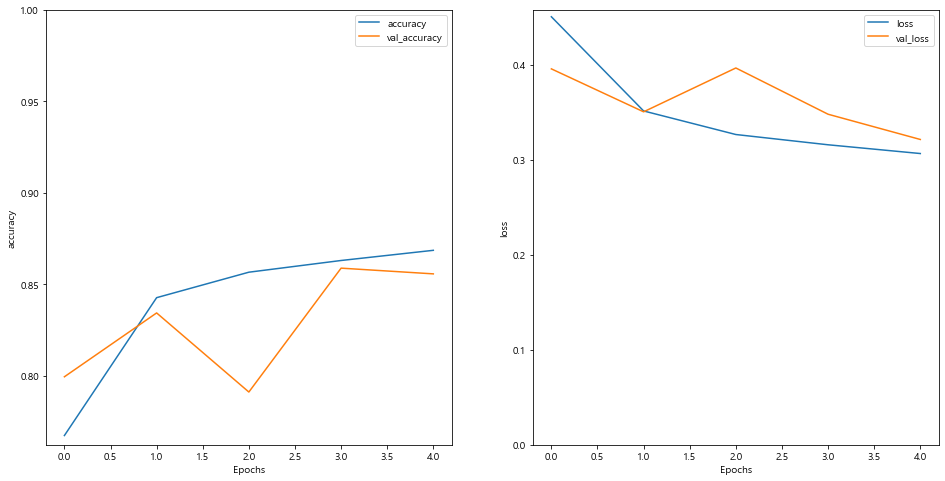

In [37]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history,'loss')
plt.ylim(0, None)

In [38]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [40]:
predictions

array([[0.9932607]], dtype=float32)

### Stack two or more LSTM layers